In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [31]:
%%R
physeq.noSmall <- subset_samples(physeq,sample_sums(physeq)>=500)

In [36]:
%%R
mdf = psmelt(physeq)

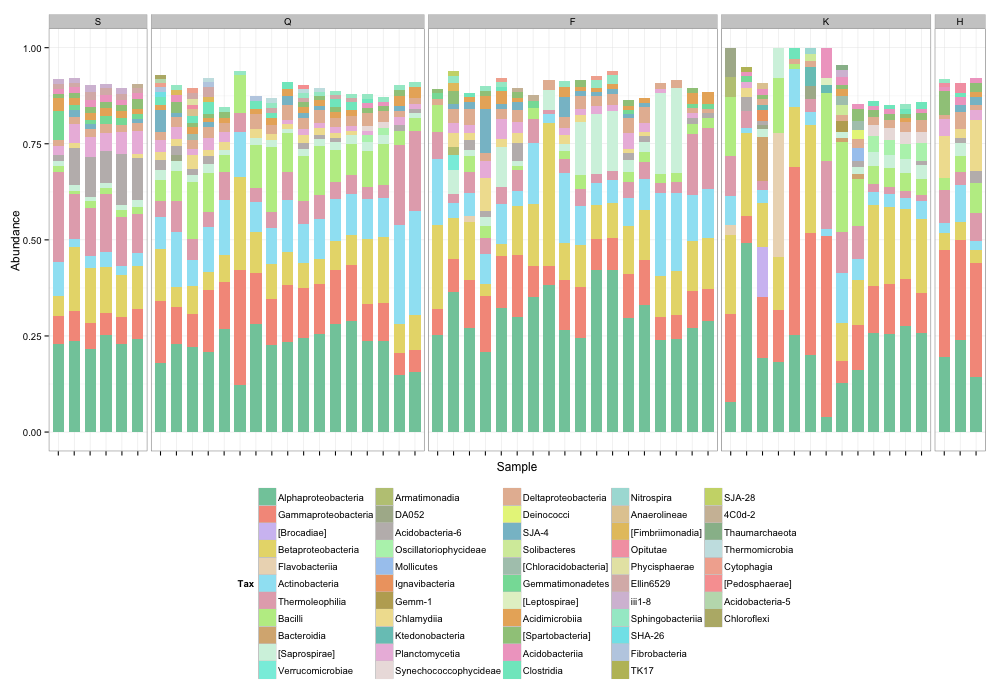

In [46]:
%%R -w 1000 -h 700

cutoff = 0.01

d.plot = mdf %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 2.5) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

trtmt.order <- c("S","Q","F","K","H")
d.plot$Trtmt = factor(d.plot$Trtmt, levels=trtmt.order)


d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank(), legend.position="bottom")

p

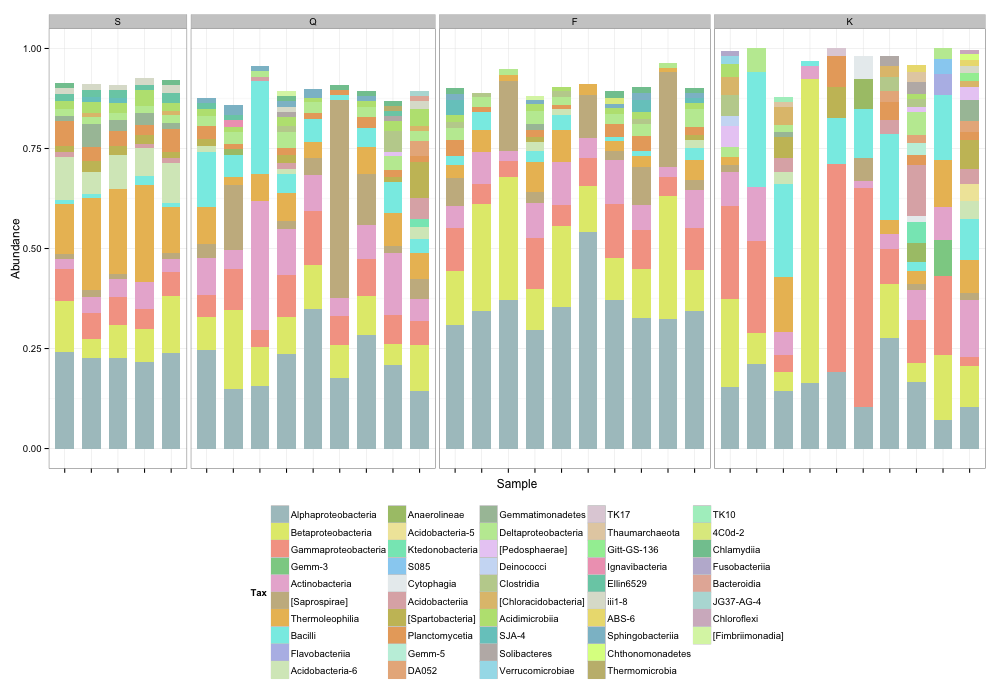

In [47]:
%%R -w 1000 -h 700

cutoff = 0.01

d.plot = mdf %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 3) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

trtmt.order <- c("S","Q","F","K","H")
d.plot$Trtmt = factor(d.plot$Trtmt, levels=trtmt.order)


d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank(), legend.position="bottom")

p